In [28]:
%run ./import_ap.ipynb

import apple_pie as ap
import brutils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

exp = ap.make_cur_exper()

reading in wells : 0.79 seconds
all exper init : 1.31 seconds


In [5]:
c = brutils.one_value(exp.condits)
cdf = pd.DataFrame(c.dists)
cdf = cdf.sort_index(axis=1)
cdf_stats = cdf.apply(pd.DataFrame.describe, axis=1)

**get_natural_cubic_spline_model code hidden bellow**

In [6]:
# https://stackoverflow.com/a/51359826

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline


def get_natural_cubic_spline_model(x, y, minval=None, maxval=None, n_knots=None, knots=None):
    """
    Get a natural cubic spline model for the data.

    For the knots, give (a) `knots` (as an array) or (b) minval, maxval and n_knots.

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.

    Parameters
    ----------
    x: np.array of float
        The input data
    y: np.array of float
        The outpur data
    minval: float 
        Minimum of interval containing the knots.
    maxval: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.

    Returns
    --------
    model: a model object
        The returned model will have following method:
        - predict(x):
            x is a numpy array. This will return the predicted y-values.
    """

    if knots:
        spline = NaturalCubicSpline(knots=knots)
    else:
        spline = NaturalCubicSpline(max=maxval, min=minval, n_knots=n_knots)

    p = Pipeline([
        ('nat_cubic', spline),
        ('regression', LinearRegression(fit_intercept=True))
    ])

    p.fit(x, y)

    return p


class AbstractSpline(BaseEstimator, TransformerMixin):
    """Base class for all spline basis expansions."""

    def __init__(self, max=None, min=None, n_knots=None, n_params=None, knots=None):
        if knots is None:
            if not n_knots:
                n_knots = self._compute_n_knots(n_params)
            knots = np.linspace(min, max, num=(n_knots + 2))[1:-1]
            max, min = np.max(knots), np.min(knots)
        self.knots = np.asarray(knots)

    @property
    def n_knots(self):
        return len(self.knots)

    def fit(self, *args, **kwargs):
        return self


class NaturalCubicSpline(AbstractSpline):
    """Apply a natural cubic basis expansion to an array.
    The features created with this basis expansion can be used to fit a
    piecewise cubic function under the constraint that the fitted curve is
    linear *outside* the range of the knots..  The fitted curve is continuously
    differentiable to the second order at all of the knots.
    This transformer can be created in two ways:
      - By specifying the maximum, minimum, and number of knots.
      - By specifying the cutpoints directly.  

    If the knots are not directly specified, the resulting knots are equally
    space within the *interior* of (max, min).  That is, the endpoints are
    *not* included as knots.
    Parameters
    ----------
    min: float 
        Minimum of interval containing the knots.
    max: float 
        Maximum of the interval containing the knots.
    n_knots: positive integer 
        The number of knots to create.
    knots: array or list of floats 
        The knots.
    """

    def _compute_n_knots(self, n_params):
        return n_params

    @property
    def n_params(self):
        return self.n_knots - 1

    def transform(self, X, **transform_params):
        X_spl = self._transform_array(X)
        if isinstance(X, pd.Series):
            col_names = self._make_names(X)
            X_spl = pd.DataFrame(X_spl, columns=col_names, index=X.index)
        return X_spl

    def _make_names(self, X):
        first_name = "{}_spline_linear".format(X.name)
        rest_names = ["{}_spline_{}".format(X.name, idx)
                      for idx in range(self.n_knots - 2)]
        return [first_name] + rest_names

    def _transform_array(self, X, **transform_params):
        X = X.squeeze()
        try:
            X_spl = np.zeros((X.shape[0], self.n_knots - 1))
        except IndexError: # For arrays with only one element
            X_spl = np.zeros((1, self.n_knots - 1))
        X_spl[:, 0] = X.squeeze()

        def d(knot_idx, x):
            def ppart(t): return np.maximum(0, t)

            def cube(t): return t*t*t
            numerator = (cube(ppart(x - self.knots[knot_idx]))
                         - cube(ppart(x - self.knots[self.n_knots - 1])))
            denominator = self.knots[self.n_knots - 1] - self.knots[knot_idx]
            return numerator / denominator

        for i in range(0, self.n_knots - 2):
            X_spl[:, i+1] = (d(i, X) - d(self.n_knots - 2, X)).squeeze()
        return X_spl

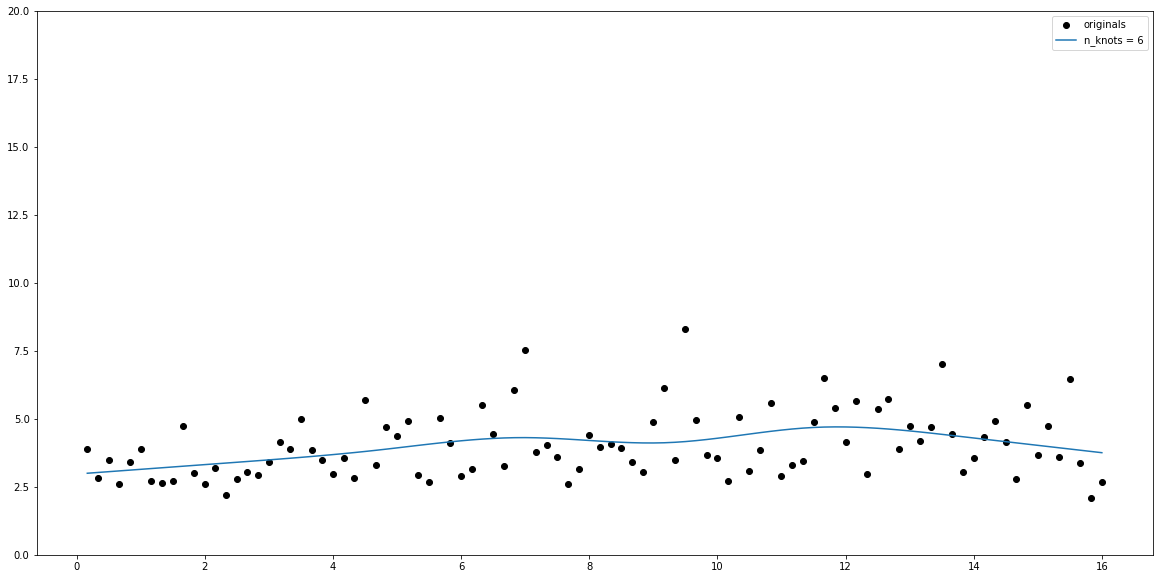

In [91]:

plt.figure(figsize=(20,10))

y50 = cdf_stats['50%']

time = np.array([n/6 for n in range(1,len(y50)+1)])
x = time


y75 = cdf_stats['75%']
y25 = cdf_stats['25%']
# The number of knots can be used to control the amount of smoothness
model_6 = get_natural_cubic_spline_model(x, y50, minval=min(x), maxval=max(x), n_knots=6)
model_15 = get_natural_cubic_spline_model(x, y50, minval=min(x), maxval=max(x), n_knots=15)
y_est_6 = model_6.predict(x)
y_est_15 = model_15.predict(x)

model75  = get_natural_cubic_spline_model(x, y75, minval=min(x), maxval=max(x), n_knots=6)
y_est75 = model75.predict(x)

model25  = get_natural_cubic_spline_model(x, y25, minval=min(x), maxval=max(x), n_knots=6)

y_est25 = model25.predict(x)


# plt.fill_between(x, y_est_6, y_est75, label='median-to-upper-quartile')
# plt.fill_between(x, y_est25, y_est_6, label='lower-quartile-to-median')
# # plt.fill_between(cdf_stats.index,cdf_stats['25%'],cdf_stats['50%'])

plt.plot(x, y50, ls='', marker='o', label='originals', color='black')
plt.plot(x, y_est_6, label='n_knots = 6')
#plt.plot(x, y_est_15,  label='n_knots = 15')
ax = plt.gca()
ax.set_ylim(0,20)
plt.legend(); plt.show()


In [159]:
def plot_cube_spline(x,y,knots) :
    plt.figure(figsize=(10,10))
    model = get_natural_cubic_spline_model(x, y, minval=min(x), maxval=max(x), n_knots=knots)
    y_predicted = model.predict(x)
    plt.plot(x, y, ls='', marker='o', label='raw data') # ls='' hides line
    plt.plot(x, y_predicted, label='cubic splines with {} knots'.format(knots))
#     ax = plt.gca()
#     ax.set_ylim(0,20)
    #plt.axes().set_aspect('equal', 'datalim')
    ax=plt.gca()
    ax.set_aspect('equal', 'datalim')
    plt.legend(); plt.show()
    
    print(r_squared(y,y_predicted))
    #for y, f in zip(y,y_predicted)
    
    
    #return y_est
from scipy import stats

def sum_of_squares(bs,cs) :
    """ currently assumes inputs are same length """
    ss = 0
    for b,c in zip(bs,cs) :
        ss += (b-c)**2
    return ss
    
def r_squared(y,yp) :
    """ currently assumes inputs are same length """
    
    y_stats = stats.describe(y)
#     print(y_stats)
    ss_tot = sum_of_squares(y, [y_stats.mean]*len(y))
    ss_res = sum_of_squares(y,yp)
#     print(ss_tot/len(y))
#     print(ss_res/len(y))
#     print((ss_res-ss_tot)/ss_tot)
    r_squared = 1 - (ss_res/ss_tot)
    return(r_squared)
    
#     #print(y_stats.mean)
#     sum_of_res = 0  # res->residules
#     for obs, pre in zip(y,yp) : # obs-> observed, pre->predicted
#         sum_of_res += (obs-pre)**2
#     vari_res = sum_of_res/y_stats
    
#     r_squared = (y_stats.varaiance)
    
    
    
    

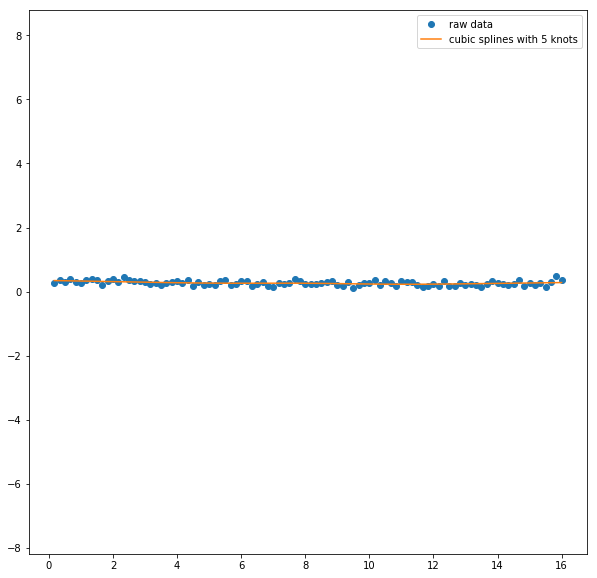

0.1625186586676194


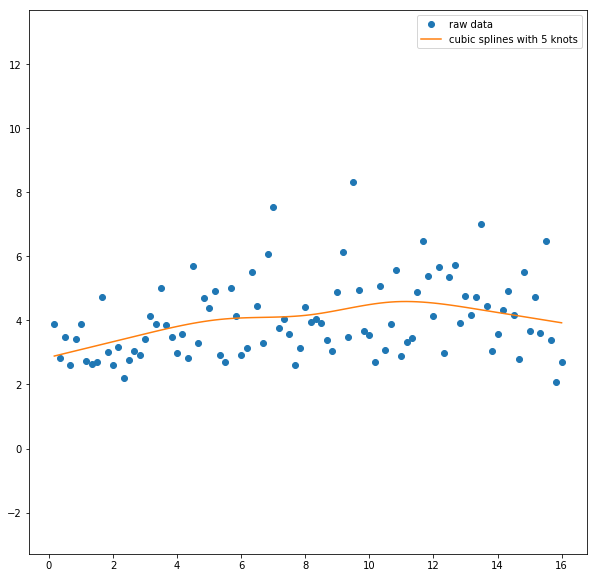

0.1395478752550563


In [160]:
time = np.array([n/6 for n in range(1,len(y50)+1)])
# plot_cube_spline(cdf_stats['50%'], time, 5)

#plot_cube_spline(time, np.log(cdf_stats['50%']), 3)
#print((np.log(time)))
plot_cube_spline((time), 1/(cdf_stats['50%']), 5)
plot_cube_spline(time, cdf_stats['50%'], 5)

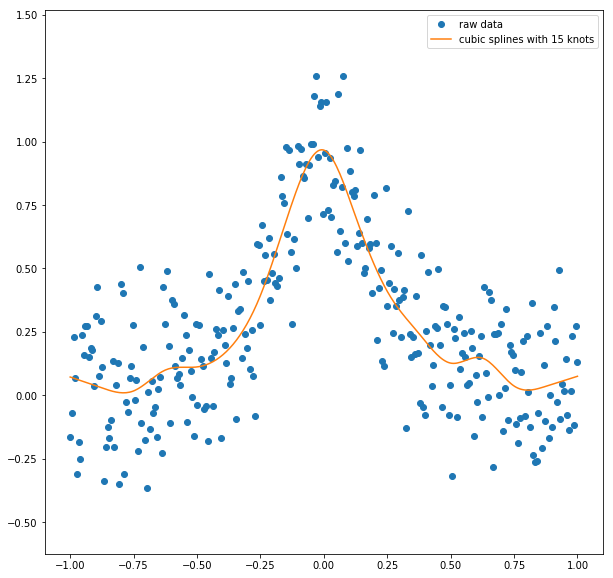

0.6858163566605338


In [161]:
def func(x):
    return 1/(1+25*x**2)

# make example data
x = np.linspace(-1,1,300)
y = func(x) + np.random.normal(0, 0.2, len(x))
plot_cube_spline(x,y,15)


In [162]:
cdf_stats.to_excel('butts_stats.xlsx')

In [163]:
ihey = cdf_stats['50%']

In [164]:
ihex = time

In [152]:
y_prime = []
x_prime = []
ang = np.pi/4
print(ang)
for i in range(len(ihey)) :
    x_prime.append(ihex[i]*np.cos(ang)-ihey[i]*np.sin(ang))
    y_prime.append(ihey[i]*np.cos(ang)+ihex[i]*np.sin(ang))

0.7853981633974483


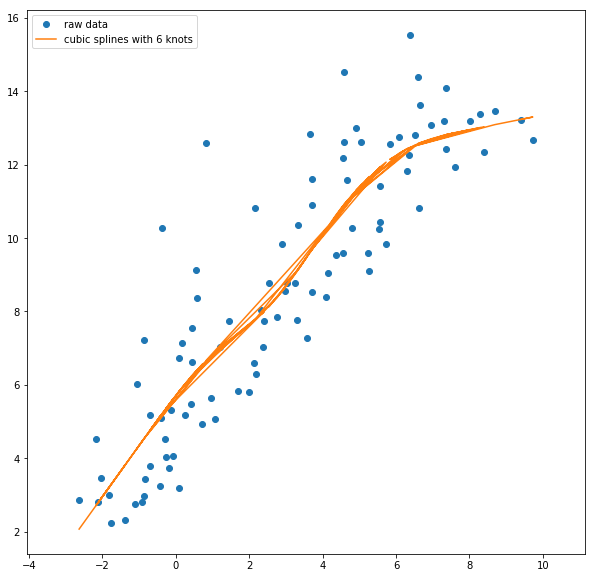

0.7980315785855214


In [167]:
x1 = np.array(x_prime)
y1 = np.array(y_prime)
len(y1)

plot_cube_spline(x1,y1,6)
omgl = pd.DataFrame([ihex,ihey])
omgl.transpose()
omgl.to_excel('omgl2.xlsx')
#plt.plot(x1,y1,ls='',marker='o')
#plt.show()

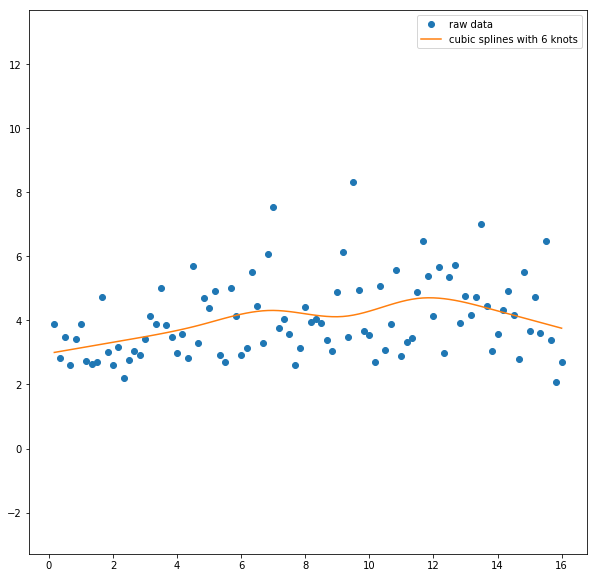

0.15082810082710862


In [166]:
# plt.plot(ihex,ihey,ls='',marker='o')
# ax=plt.gca()
# ax.set_aspect('equal', 'datalim')

# plt.show()
plot_cube_spline(ihex,ihey,6)
